Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
# Importing all the required libraries 
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

In [2]:
# If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


this assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respe
y.

In [3]:
# Defining the path for train and test images
path = '/content/gdrive/MyDrive/Assignment/Skin cancer'
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(path +"/Train")
data_dir_test = pathlib.Path(path +"/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

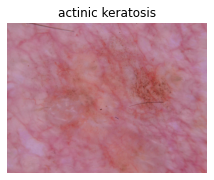

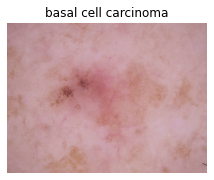

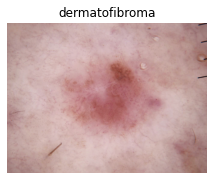

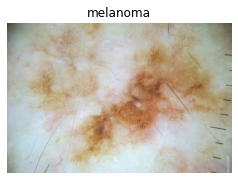

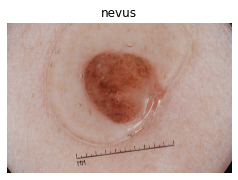

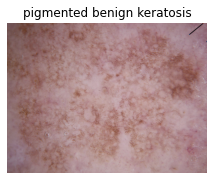

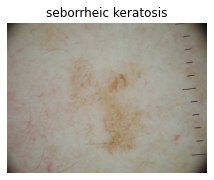

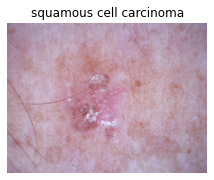

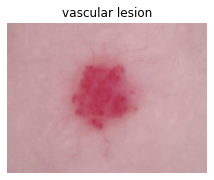

In [9]:
import matplotlib.pyplot as plt
num=0
for dirpath, dirnames, filenames in os.walk(str(data_dir_train)):
    for filename in [i for i in filenames if i.endswith(".jpg")][:1]:
        img = PIL.Image.open(str(dirpath)+"/"+str(filename))
        plt.figure (figsize = (16,16)) 
        plt.subplot(5,2,num+1)
        plt.title(str(dirpath).split('/')[-1])
        plt.axis('off')
        plt.imshow(img)
        num=num+1

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

Model 1 

In [11]:
# Standardize Data of RGB channel value through normalization of the 3 layer data using rescaling
# Observing the value of pixels 
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.13013184 0.916992


As seen above, all the pixel values of images are converted from [0,255] to [0,1]

In [12]:

# getting the number of classes in the dataset
num_classes = len(class_names)

# building the model with Sequential with relu - activation function & softmax 
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation = 'softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### Todo, choose an appropirate optimiser and loss function
# Using catrgorical entropy since there are multi-classes 
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 129s 2s/step - loss: 2.0097 - accuracy: 0.2723 - val_loss: 1.7524 - val_accuracy: 0.3893
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.6627 - accuracy: 0.4023 - val_loss: 1.6027 - val_accuracy: 0.4653
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.5314 - accuracy: 0.4632 - val_loss: 1.4310 - val_accuracy: 0.5145
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3604 - accuracy: 0.5156 - val_loss: 1.4467 - val_accuracy: 0.5056
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 1.2704 - accuracy: 0.5564 - val_loss: 1.3966 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.1881 - accuracy: 0.5765 - val_loss: 1.3949 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 1.1316 - accuracy: 0.5882 - val_loss: 1.4029 - val_accuracy: 0.5302
Epoch 8/20
56/56 [======

### Visualizing training results

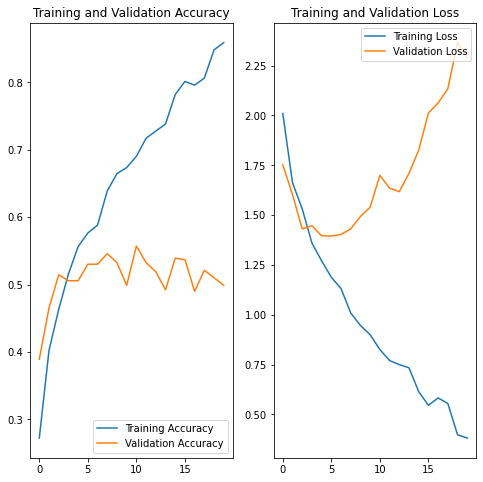

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
# Observing the values of accuracy for training and validation sets 

loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_val, accuracy_val = model.evaluate(val_ds, verbose=1)
print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_val)
print("Loss: ",loss)
print("Validation Loss", loss_val)

14/14 [==============================] - 0s 11ms/step - loss: 2.2898 - accuracy: 0.4989
Accuracy:  0.87109375
Validation Accuracy:  0.49888142943382263
Loss:  0.33681294322013855
Validation Loss 2.2897770404815674


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

The accuracy of training set is very high comparing to the accuracy of validation set, 

this shows that the model has learnt all the instances of the set and the model is not a generalized one. 

This indicates the model is overfit and there is a need for model generalization. 

### Write your findings here

In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Using Image flip, rotate, zoom so that the model will learn more about each class. 
data_augmentation = Sequential([
    layers.RandomFlip("horizontal",input_shape=(180,180,3)),
    layers.RandomFlip("vertical",input_shape=(180,180,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)])

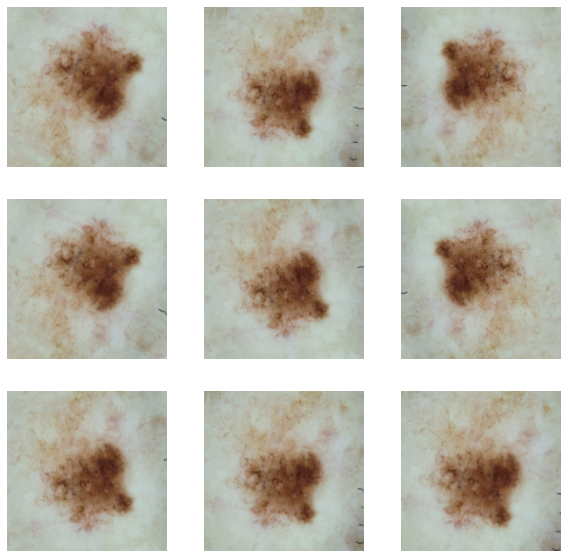

In [19]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

# dropout layers added for reducing the overfitting of model
# getting the number of classes in the dataset
# Using augumented data for building model 
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation = 'softmax')
])


### Compiling the model

In [21]:
## using adam optimizer and crossentropy for loss function and accuracy as metrics
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# printing the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [22]:
## Your code goes here, note: train your model for 20 epochs
# Value of epochs is already 20 and re-defining the same 
epochs = 20 
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 30ms/step - loss: 2.1260 - accuracy: 0.2076 - val_loss: 1.9306 - val_accuracy: 0.2796
Epoch 2/20
56/56 [==============================] - 2s 27ms/step - loss: 1.8638 - accuracy: 0.3041 - val_loss: 1.7351 - val_accuracy: 0.4116
Epoch 3/20
56/56 [==============================] - 1s 27ms/step - loss: 1.6412 - accuracy: 0.4169 - val_loss: 1.5011 - val_accuracy: 0.5101
Epoch 4/20
56/56 [==============================] - 2s 27ms/step - loss: 1.4910 - accuracy: 0.4699 - val_loss: 1.5397 - val_accuracy: 0.4653
Epoch 5/20
56/56 [==============================] - 1s 27ms/step - loss: 1.4363 - accuracy: 0.4989 - val_loss: 1.4514 - val_accuracy: 0.5034
Epoch 6/20
56/56 [==============================] - 2s 27ms/step - loss: 1.3479 - accuracy: 0.5167 - val_loss: 1.4279 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 1s 27ms/step - loss: 1.3407 - accuracy: 0.5240 - val_loss: 1.3844 - val_accuracy: 0.5235
Epoch 8/20
56

### Visualizing the results

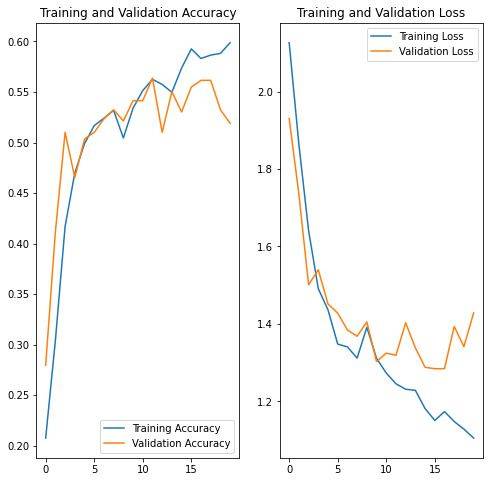

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
# Observing the values of accuracy for training and validation sets 
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_val, accuracy_val = model.evaluate(val_ds, verbose=1)
print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_val)
print("Loss: ",loss)
print("Validation Loss", loss_val)

14/14 [==============================] - 0s 11ms/step - loss: 1.4285 - accuracy: 0.5190
Accuracy:  0.59765625
Validation Accuracy:  0.5190156698226929
Loss:  1.1319756507873535
Validation Loss 1.4284875392913818


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

The validation accuracy seems not to be improved much, 
while the training accuracy has gone down to 60%. 

This indicates that the model is generalized but not performing to the mark 

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 720x720 with 0 Axes>

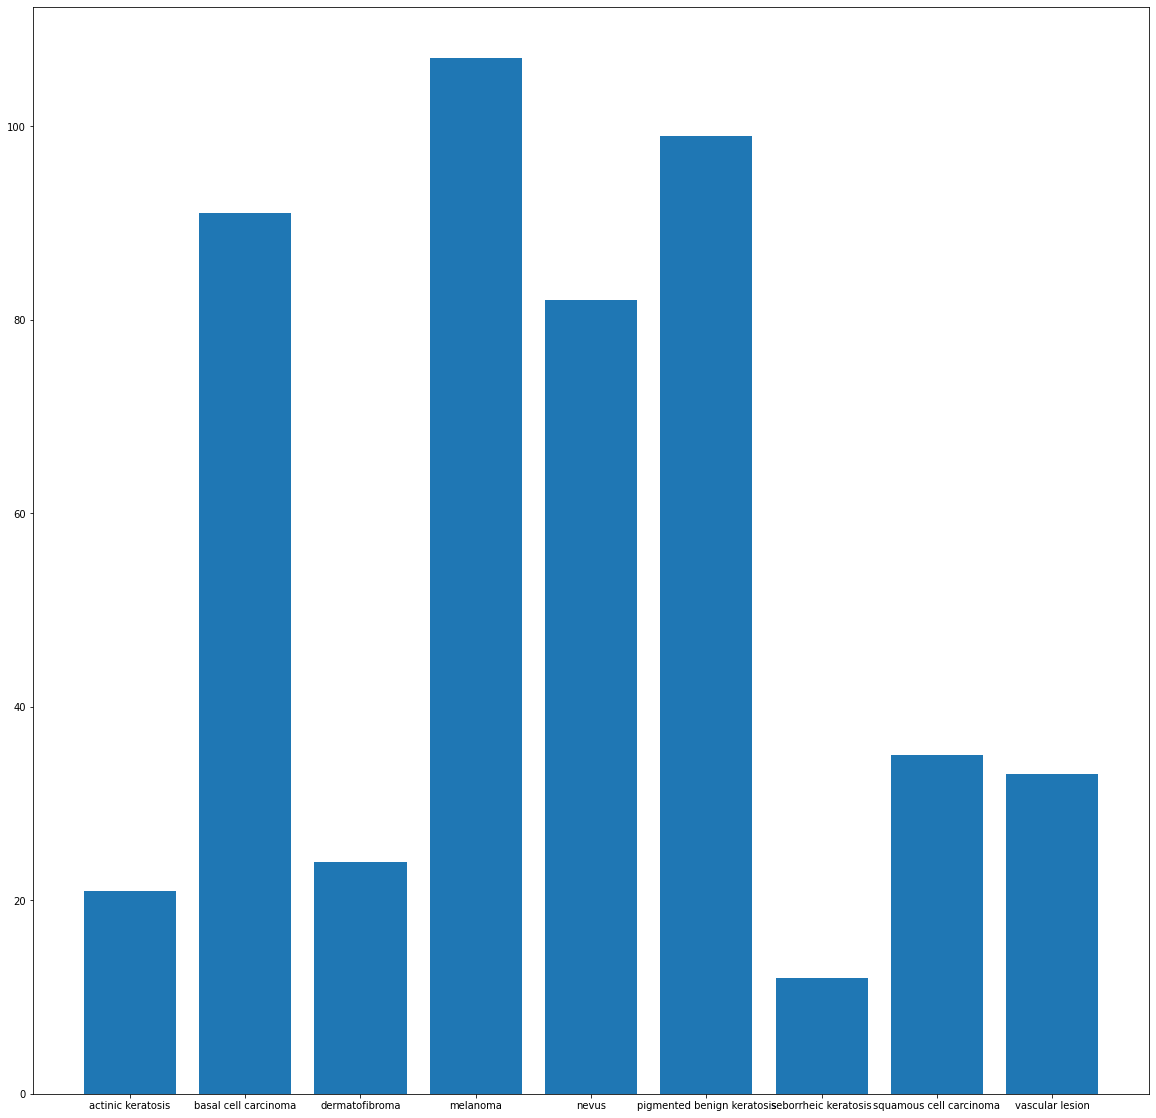

In [25]:
# Checking for Class Imbalance 
# using empty dictionary for adding the class quantity
class_data = dict()

# assigning empty lists for each class 
for i in class_names:
  class_data[i] = []

# setting the output image size
plt.figure(figsize=(10, 10))
# adding the images into the data dictionary for each class
for images, labels in train_ds:
  for i in range(9):
    class_data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))
# storing the number of images for specific class
for i in class_data:
  # getting the length and storing the dictionary
  class_data[i] = len(class_data[i]) 

i = plt.figure()
i.set_figwidth(20)
i.set_figheight(20)
# printing the plot
plt.bar(range(len(class_data)), list(class_data.values()), align='center')
plt.xticks(range(len(class_data)), list(class_data.keys()))
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?

# Seborrheic keratosis has least number of samples 
#### - Which classes dominate the data in terms proportionate number of samples?

# Melanoma has highest number of samples and dominates the dataset 

## This class imbalance will cause the model to be biased towards the more dominant class i.e., class having more number of samples 

## Therefore, the class imbalance is to be handled and new model to be generated for the same 

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
path_to_training_dataset="/content/gdrive/MyDrive/Assignment/Skin cancer/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Assignment/Skin cancer/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF2D2728F10>: 100%|██████████| 500/500 [00:19<00:00, 25.77 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Assignment/Skin cancer/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF2D64AAC90>: 100%|██████████| 500/500 [00:20<00:00, 24.87 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Assignment/Skin cancer/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF2D6507F50>: 100%|██████████| 500/500 [00:22<00:00, 22.68 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Assignment/Skin cancer/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF2D27B5590>: 100%|██████████| 500/500 [01:25<00:00,  5.85 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Assignment/Skin cancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FF2D27B5E10>: 100%|██████████| 500/500 [01:16<00:00,  6.51 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Assignment/Skin cancer/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF2D5A91A50>: 100%|██████████| 500/500 [00:18<00:00, 27.27 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Assignment/Skin cancer/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF3F2213150>: 100%|██████████| 500/500 [00:41<00:00, 11.97 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Assignment/Skin cancer/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF2D26C3910>: 100%|██████████| 500/500 [00:18<00:00, 27.42 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Assignment/Skin cancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF2D26EC0D0>: 100%|██████████| 500/500 [00:17<00:00, 28.34 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
# Importing glob library 
from glob import glob

In [30]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Assignment/Skin cancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028517.jpg_588ec4e2-88c1-4af2-ba02-91998bed181e.jpg',
 '/content/gdrive/MyDrive/Assignment/Skin cancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029713.jpg_82b1d1a3-83b8-487e-be4d-76581672a48c.jpg',
 '/content/gdrive/MyDrive/Assignment/Skin cancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033705.jpg_6bc2f0f7-b5ed-409b-8347-50d2a473cbe6.jpg',
 '/content/gdrive/MyDrive/Assignment/Skin cancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026525.jpg_d91e68e4-e8d0-46ed-8276-7ab635ab7dd7.jpg',
 '/content/gdrive/MyDrive/Assignment/Skin cancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029900.jpg_a68f72d9-cdf1-426c-8a8f-8f9556c181a7.jpg',
 '/content/gdrive/MyDrive/Assignment/Skin cancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026650.jpg_11a2ee80-0f36-403b-9df4-ba1994ea8445.jpg'

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [32]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [34]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

Now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [36]:
data_dir_train="/content/gdrive/MyDrive/Assignment/Skin cancer/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [38]:
# performing autotune
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Creating model using data_augumentation set after handling class imbalance 
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # layers.Conv2D(128, 3, padding='same', activation='relu'),
  # layers.MaxPooling2D(),
  # layers.Conv2D(256, 3, padding='same', activation='relu'),
  # layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation = 'softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

#### **Todo:**  Train your model

In [40]:
epochs = 30
## using 30 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 33s 61ms/step - loss: 1.8197 - accuracy: 0.2991 - val_loss: 1.4601 - val_accuracy: 0.4558
Epoch 2/30
169/169 [==============================] - 4s 26ms/step - loss: 1.4768 - accuracy: 0.4306 - val_loss: 1.3074 - val_accuracy: 0.4996
Epoch 3/30
169/169 [==============================] - 4s 26ms/step - loss: 1.4151 - accuracy: 0.4575 - val_loss: 1.3071 - val_accuracy: 0.4944
Epoch 4/30
169/169 [==============================] - 4s 27ms/step - loss: 1.3465 - accuracy: 0.4803 - val_loss: 1.2462 - val_accuracy: 0.5278
Epoch 5/30
169/169 [==============================] - 4s 26ms/step - loss: 1.2703 - accuracy: 0.5167 - val_loss: 1.1924 - val_accuracy: 0.5397
Epoch 6/30
169/169 [==============================] - 5s 27ms/step - loss: 1.2508 - accuracy: 0.5223 - val_loss: 1.1965 - val_accuracy: 0.5353
Epoch 7/30
169/169 [==============================] - 5s 29ms/step - loss: 1.1885 - accuracy: 0.5517 - val_loss: 1.0843 - val_accuracy: 0.580

#### **Todo:**  Visualize the model results

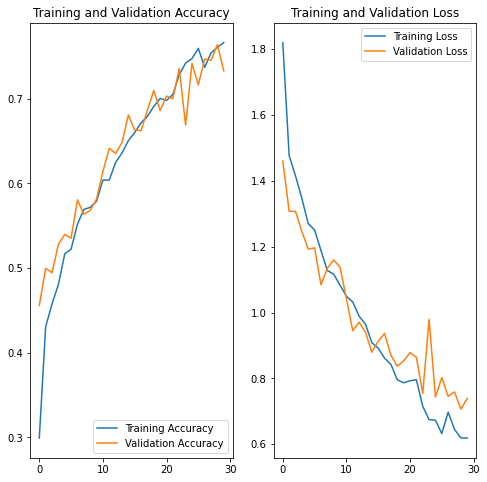

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
# Observing the values of accuracy for training and validation sets 

loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_val, accuracy_val = model.evaluate(val_ds, verbose=1)
print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_val)
print("Loss: ",loss)
print("Validation Loss", loss_val)

43/43 [==============================] - 0s 11ms/step - loss: 0.7391 - accuracy: 0.7327
Accuracy:  0.8028560876846313
Validation Accuracy:  0.7327394485473633
Loss:  0.5158362984657288
Validation Loss 0.7391117811203003


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



As seen above, 

The train set and the validation set both are having 76% and 69% respectively.

This indicates the model is performing same in the unseen data since the overfitting and class imbalance is handled 

Now, this model can be verified by test data. 

If the data is performing well in the test data, this model can be standardized. 

If the test data is having less accuracy, then new model can be built with 216, 512 neurons for building more accurate model 